In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

In [2]:
%matplotlib inline

In [3]:
t = np.linspace(-1.5*np.pi, 1.5*np.pi, 1000)

In [4]:
x = np.cos(1*t)
y = np.sin(t)*t
z = np.sin(4*t)

In [5]:
Y = np.vstack([x, y, z])

In [6]:
angle = (3/4)*np.pi
angle=0
R = np.array([[1, 0, 0],[0, np.cos(angle), -np.sin(angle)], [0, np.sin(angle), np.cos(angle)]])

In [7]:
Y_data = R @ Y

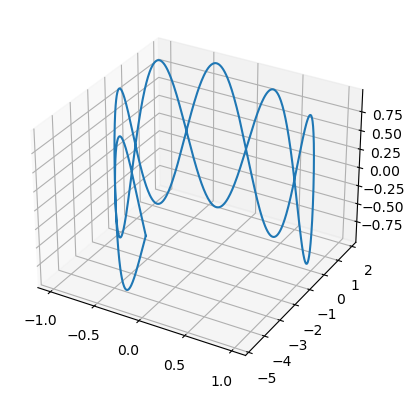

In [8]:
%matplotlib inline
ax = plt.figure().add_subplot(projection='3d')
ax.plot(Y_data[0], Y_data[1], Y_data[2])

In [9]:
Y_data = torch.tensor(Y_data)

In [10]:
Y_data = Y_data.T

In [11]:
C = torch.cdist(Y_data, Y_data)

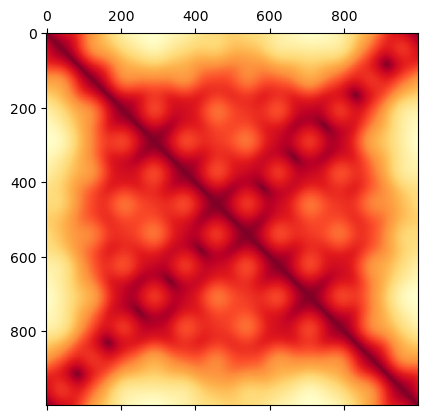

In [12]:
plt.matshow(C, cmap='YlOrRd_r')

In [13]:
X = torch.tensor(t).type(torch.float)[:, None]
Y = C.type(torch.float)

In [14]:
from gpzoo.gp import SVGP
from gpzoo.kernels import NSF_RBF
from torch import nn
from torch import optim
from tqdm.autonotebook import tqdm
from torch import distributions

/gladstone/engelhardt/home/lchumpitaz/gitclones/GPzoo/gpzoo/utilities.py:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [ ]:
class DeepGP(nn.Module):
    def __init__(self, gp1, gp2, gp3, noise=0.1):
        super().__init__()
        self.gp1 = gp1
        self.gp2 = gp2
        self.gp3 = gp3

        self.noise = nn.Parameter(torch.tensor(noise))

    def forward(self, X, E=1, verbose=False, **kwargs):
        qF1, qU1, pU1 = self.gp1(X, verbose=verbose, **kwargs)
        
        X2 = qF1.resample().T    
        qF2, qU2, pU2 = self.gp2(X2, verbose=verbose, **kwargs)
        
        
        X3 = qF2.rsample().T
        qF3, qU3, pU3 = self.gp3(X3, verbose=verbose, **kwargs)
        
        
        
        F3 = qF3.rsample((E, ))
        noise = torch.nn.functional.softplus(self.noise) #ensure positive
        pY = distributions.Normal(F3, noise)

        return pY, qF1, qU1, pU1, qF2, qU2, pU2, qF3, qU3, pU3
    
    
    def predict(self, X, verbose=False, **kwargs):
        qF1, qU1, pU1 = self.gp1(X, verbose=verbose, **kwargs)
        
        X2 = qF1.mean.T    
        qF2, qU2, pU2 = self.gp2(X2, verbose=verbose, **kwargs)
        
        
        X3 = qF2.mean.T
        qF3, qU3, pU3 = self.gp3(X3, verbose=verbose, **kwargs)
    

        return qF1, qU1, pU1, qF2, qU2, pU2, qF3, qU3, pU3

In [15]:
class CustomLikelihood(nn.Module):
    def __init__(self, gp1, gp2, gp3, noise=0.1):
        super().__init__()
        self.gp1 = gp1
        self.gp2 = gp2
        self.gp3 = gp3

        self.noise = nn.Parameter(torch.tensor(noise))

    def forward(self, X, E=1, verbose=False, **kwargs):
        qF1, qU1, pU1 = self.gp1(X, verbose=verbose, **kwargs)
        
        X2 = qF1.mean.T    
        qF2, qU2, pU2 = self.gp2(X2, verbose=verbose, **kwargs)
        
        
        X3 = qF2.rsample().T
        qF3, qU3, pU3 = self.gp3(X3, verbose=verbose, **kwargs)
        
        
        
        F3 = qF3.rsample((E, ))
        noise = torch.nn.functional.softplus(self.noise) #ensure positive
        pY = distributions.Normal(F3, noise)

        return pY, qF1, qU1, pU1, qF2, qU2, pU2, qF3, qU3, pU3
    
    
    def predict(self, X, verbose=False, **kwargs):
        qF1, qU1, pU1 = self.gp1(X, verbose=verbose, **kwargs)
        
        X2 = qF1.mean.T    
        qF2, qU2, pU2 = self.gp2(X2, verbose=verbose, **kwargs)
        
        
        X3 = qF2.mean.T
        qF3, qU3, pU3 = self.gp3(X3, verbose=verbose, **kwargs)
    

        return qF1, qU1, pU1, qF2, qU2, pU2, qF3, qU3, pU3

In [16]:
L1 = 2
M = 300
idx = torch.multinomial(torch.ones(X.shape[0]), num_samples=M, replacement=False)
kernel = NSF_RBF(L=L1, sigma=0.5, lengthscale=1.2)
gp = SVGP(kernel, M=M, jitter=1e-1)
gp.Lu = nn.Parameter(1e-2*torch.eye(M).expand(L1, M, M).clone())
gp.Z = nn.Parameter(torch.tensor(X[idx]), requires_grad=False)
mu =  torch.squeeze(torch.stack((torch.torch.sin(gp.Z), torch.cos(gp.Z))))
gp.mu = nn.Parameter(mu)


L2 = 3
kernel2 = NSF_RBF(L=L2, sigma=0.5, lengthscale=1.2)
gp2 = SVGP(kernel2, M=M, jitter=1e-1)
gp2.Lu = nn.Parameter(1e-2*torch.eye(M).expand(L2, M, M).clone())
gp2.Z = nn.Parameter(mu.T, requires_grad=False)

mu2 = torch.squeeze(torch.stack((torch.torch.sin(gp.Z), torch.cos(gp.Z), torch.torch.sin(gp.Z))))
gp2.mu = nn.Parameter(mu2)


L3 = 1000
kernel3 = NSF_RBF(L=L3, sigma=0.5, lengthscale=1.2)
gp3 = SVGP(kernel3, M=M, jitter=1e-1)
gp3.Lu = nn.Parameter(1e-2*torch.eye(M).expand(L3, M, M).clone())
gp3.Z = nn.Parameter(mu2.T, requires_grad=True)
gp3.mu = nn.Parameter(Y[idx].T)



/tmp/ipykernel_2619043/4088531043.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp.Z = nn.Parameter(torch.tensor(X[idx]), requires_grad=False)


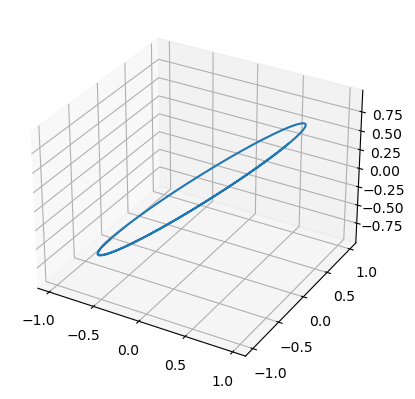

In [17]:
import matplotlib.pyplot as plt

ax = plt.figure().add_subplot(projection='3d')

qF, _, _ = gp(X)

qF, _, _ = gp2(qF.mean.T)
some_mean = qF.mean.detach().numpy()

ax.plot(some_mean[0], some_mean[1], some_mean[2])

In [18]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=1)

In [19]:
model = CustomLikelihood(gp1=gp, gp2=gp2, gp3=gp3, noise=0.1)
model.to(device)

CustomLikelihood(
  (gp1): SVGP(
    (kernel): NSF_RBF()
  )
  (gp2): SVGP(
    (kernel): NSF_RBF()
  )
  (gp3): SVGP(
    (kernel): NSF_RBF()
  )
)

In [20]:
X_train = X.to(device)
Y_train = Y.to(device)

In [21]:
def train(model, optimizer, X, y, device, steps=200, E=20, **kwargs):
    losses = []

    means = []
    scales = []

    for it in tqdm(range(steps)):

        optimizer.zero_grad()
        pY, qF1, qU1, pU1, qF2, qU2, pU2, qF3, qU3, pU3 = model.forward(X=X, E=E, **kwargs)
        if (it%10)==0:
            means.append(qF2.mean.detach().cpu().numpy())
            scales.append(qF2.scale.detach().cpu().numpy())

        logpY = pY.log_prob(y)

        ELBO = (logpY).mean(axis=0).sum()
        ELBO -= torch.sum(distributions.kl_divergence(qU1, pU1))
        ELBO -= torch.sum(distributions.kl_divergence(qU2, pU2))
        ELBO -= torch.sum(distributions.kl_divergence(qU3, pU3))

        loss = -ELBO
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

    with torch.no_grad():
        if device.type=='cuda':
            torch.cuda.empty_cache()

    return losses, means, scales

In [22]:
kernel.lengthscale.requires_grad = False
gp.Lu.requires_grad=False
gp.mu.requires_grad=False


kernel2.lengthscale.requires_grad = False
gp2.Lu.requires_grad=False
gp2.mu.requires_grad=True


kernel3.lengthscale.requires_grad = False
gp3.Lu.requires_grad=False
gp3.mu.requires_grad=False


model.noise.requires_grad=False


In [23]:
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-2)

In [ ]:
model.to(device)
losses, means, scales = train(model, optimizer, X_train, Y_train, device, steps=6000, E=10)

  0%|          | 0/6000 [00:00<?, ?it/s]

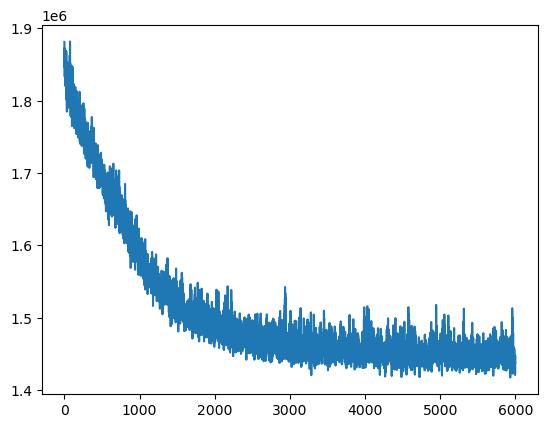

In [38]:
plt.plot(losses)

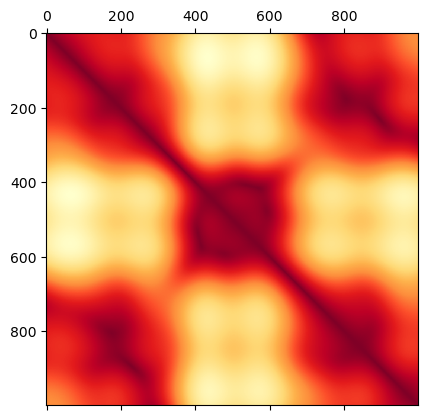

In [39]:
curr_mean = torch.tensor(means[-1].T)
mat = torch.cdist(curr_mean, curr_mean)
plt.matshow(mat, cmap='YlOrRd_r')

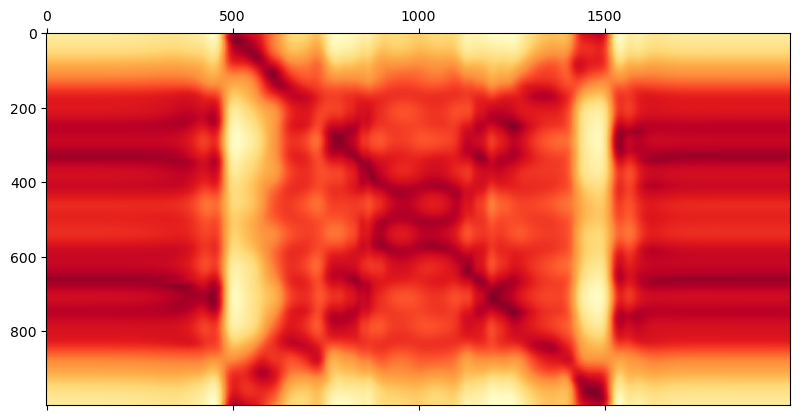

In [40]:
model.cpu()
X_test = torch.tensor(np.linspace(-3*np.pi, 3*np.pi, 2000)[:, None], dtype=torch.float)
qF1, qU1, pU1, qF2, qU2, pU2, qF3, qU3, pU3 = model.predict(X=X_test)
plt.matshow(qF3.mean.detach().numpy(), cmap='YlOrRd_r')

In [46]:
qF1, _, _ = model.gp1(X)

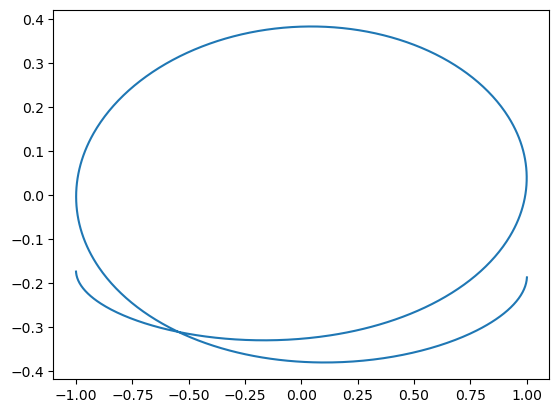

In [51]:
plt.plot(qF1.mean[0].detach(), qF1.mean[1].detach())

In [41]:
def plot_mean(ax, curr_mean):
    ax.plot(curr_mean[0], curr_mean[1], curr_mean[2], label='parametric curve')
    ax.legend()

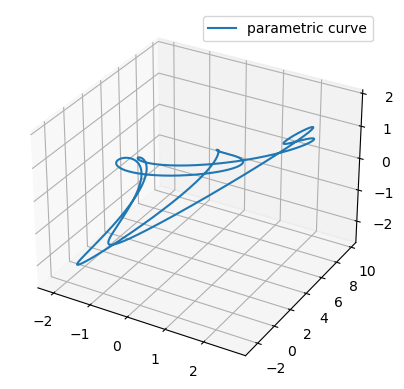

In [42]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
fig = plt.figure()
ax = fig.add_subplot(projection='3d')



plot_mean(ax, qF2.mean.detach().numpy())



In [ ]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation


fig = plt.figure()
ax = fig.add_subplot(projection='3d')

def update(iteration):
    ax.cla()
        
    curr_mean = means[iteration]
    
    
    plot_mean(ax, curr_mean)
#     fig.suptitle(f"Iteration: {iteration}, Loss: {losses[iteration*10]:0.2f}")
#     fig.tight_layout()
    print('hi', iteration)


anim = FuncAnimation(fig, update, frames=np.arange(0, 600, 1), interval=100)
# anim.save('pnmf.mp4',
#          writer=animation.FFMpegWriter(fps=50, bitrate=2000, codec='h264'),
#          dpi=50)
anim.save("deep_means.mp4", fps=30, dpi=100)